# Explore TensorFlow Default Augmentation Methods

In this notebook, we will explore the effect of some default data augmentation methods provided by TensorFlow applied on original color images (without prior normalization) from processed Waymo dataset (processed data in the `processed` folder in the data directory `./data/waymo`). The data frames in the processed tfrecord files only contain the images of the front camera including ground truth annotations for the sake of reducing required storage capacity.

In [1]:
import functools
import numpy as np
import os
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf

# Enable TensorFlow eager execution mode
tf.compat.v1.enable_eager_execution()

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from object_detection.core import preprocessor
from object_detection import inputs
from object_detection.core import standard_fields as standard_fields

from utils import get_dataset
from utils import get_label_map

# This is needed to display the images.
%matplotlib inline

In [2]:
#tfrecord_filepath = "./data/waymo/training_and_validation/*.tfrecord"
#tfrecord_filepath = "./data/waymo/train/*.tfrecord"
tfrecord_filepath = "./data/waymo/val/*.tfrecord"
#tfrecord_filepath = "./data/waymo/test/*.tfrecord"
dataset = get_dataset(tfrecord_filepath)

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/val/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/val/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 15
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [3]:
# get object category index and object classname index
category_idx, classname_idx = get_label_map(label_map_path='./label_map.pbtxt')
print("Object category index:     {}".format(category_idx))
print("Object classname index:    {}".format(classname_idx))

# get number of availabel object classes
num_of_object_classes = len(category_idx)
print("Number of object classes:  {}".format(num_of_object_classes))

Object category index:     {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
Object classname index:    {'vehicle': 1, 'pedestrian': 2, 'cyclist': 4}
Number of object classes:  3


In [4]:
#class_color_idx = {1: [0, 0, 1], 2: [1, 0, 0], 4: [0, 1, 0]}
class_color_idx = {1: u'#1f77b4', 2: u'#ff7f0e', 4: u'#2ca02c'}
# create an array with class-based colors
custom_colors = list(class_color_idx.values())
# define custom color palette
custom_color_palette = sns.set_palette(sns.color_palette())

In [5]:
# Get the size and contents of one sample frame
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [6]:
# get image shape for the front camera images
image_height, image_width, color_channels = 0, 0, 0
for frame in dataset.shuffle(100).take(1):
    # get image from frame
    image = frame['image'].numpy()
    image_height, image_width, color_channels = image.shape
    # get ground truth object bounding boxes
    bboxes = frame['groundtruth_boxes'].numpy()
    # get ground truth object class indices
    classes = frame['groundtruth_classes'].numpy()
print(f'image.shape = ({image_height}, {image_width}, {color_channels})')

image.shape = (640, 640, 3)


In [7]:
print(len(bboxes))
print(bboxes)

27
[[0.47813338 0.64507705 0.5097129  0.6799461 ]
 [0.4986107  0.74853283 0.56325    0.8100471 ]
 [0.501818   0.78850067 0.5847142  0.8694231 ]
 [0.6135798  0.         0.95848715 0.20099036]
 [0.5020647  0.62961626 0.5213085  0.645406  ]
 [0.47122544 0.37615785 0.540799   0.38668436]
 [0.52624273 0.91218704 0.5938426  0.99968857]
 [0.5005844  0.86448884 0.5287099  0.86975205]
 [0.4786268  0.45066577 0.5102063  0.46053436]
 [0.48257422 0.4427709  0.50625885 0.45395532]
 [0.4904691  0.59737885 0.5250092  0.62961626]
 [0.49836397 0.62320167 0.5220486  0.6406362 ]
 [0.4988574  0.723039   0.5472135  0.75988173]
 [0.5099596  0.21776697 0.5617697  0.23289882]
 [0.48479468 0.51596296 0.5277231  0.5307659 ]
 [0.4954034  0.7376774  0.5023114  0.7412959 ]
 [0.47566637 0.32928205 0.57139176 0.34803236]
 [0.50502527 0.36924988 0.69795626 0.522871  ]
 [0.4806005  0.5417858  0.54277265 0.5858655 ]
 [0.47912022 0.4503368  0.50477856 0.45494217]
 [0.4872618  0.6416231  0.5588091  0.712348  ]
 [0.500091

In [8]:
print(len(classes))
print(classes)

27
[1 1 1 1 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 2 1 1 1 1 1 1 2]


In [9]:
# check the color pixel values on a sample image
print("RGB: min, max, mean, std = ({}, {}, {}, {})".format(
    np.min(image), np.max(image), np.mean(image), np.std(image)))
print("R  : min, max, mean, std = ({}, {}, {}, {})".format(
    np.min(image[:, :, 0]), np.max(image[:, :, 0]), np.mean(image[:, :, 0]), np.std(image[:, :, 0])))
print(" G : min, max, mean, std = ({}, {}, {}, {})".format(
    np.min(image[:, :, 1]), np.max(image[:, :, 1]), np.mean(image[:, :, 1]), np.std(image[:, :, 1])))
print("  B: min, max, mean, std = ({}, {}, {}, {})".format(
    np.min(image[:, :, 2]), np.max(image[:, :, 2]), np.mean(image[:, :, 2]), np.std(image[:, :, 2])))

RGB: min, max, mean, std = (0, 255, 79.21773030598958, 60.94822369525056)
R  : min, max, mean, std = (0, 255, 67.44563232421875, 57.71657504882603)
 G : min, max, mean, std = (0, 255, 80.5525634765625, 59.29561721138731)
  B: min, max, mean, std = (0, 255, 89.6549951171875, 63.62062630741718)


In [10]:
def display_instances(img, bboxes, classes, class_color_idx):
    """ Display a RGB color image with detected object instances by adding
        image axis-aligned bounding boxes with class-coded colors.
    
    Args:
        image [numpy.ndarray]: RGB color image as numpy array of shape (w, h, 3)
        bboxes [numpy.ndarray]: numpy array of shape (N, 4) with bounding box coordinates (ymin, xmin, ymax, xmax)
        classes [numpy.ndarray]: one-hot encoded class index of shape (100, 3) with up to 100 objects and 3 classes
    """    
    # get image shape to resize the bboxes to pixel values
    h, w, _ = img.shape
    # make a copy of the bounding box array
    bboxes_copy = np.copy(bboxes)
    # resize the bboxes to pixel values
    bboxes_copy[:, [0, 2]] *= w
    bboxes_copy[:, [1, 3]] *= h
    bboxes_copy.astype(np.int32)
    # show image and add object bounding boxes in their class-specific color
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img.astype(np.uint8))
    for bb, cl in zip(bboxes_copy, classes):
        if cl > 0: # some objects are present
            y1, x1, y2, x2 = bb
            rec = Rectangle((x1, y1), x2-x1, y2-y1, 
                            facecolor='none', edgecolor=class_color_idx[cl], linewidth=2)
            ax.add_patch(rec)
        else: # no objects are present
            continue
    plt.show()

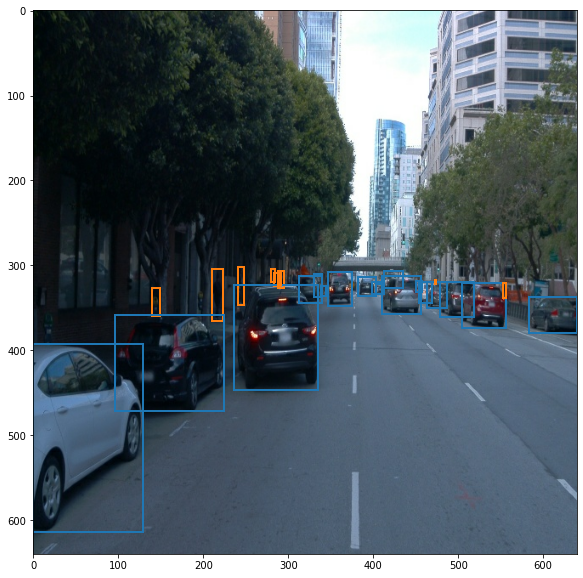

In [11]:
#%matplotlib inline
display_instances(image, bboxes, classes, class_color_idx)

## Show Augmentation Effects

In [12]:
def show_augmentation_effect(image, bboxes, classes, data_augmentation_options, class_color_idx):
    """ Show an original image and its augmented counterpart
    Args:
    - image [numpy array]: original color image array
    - bboxes [numpy arraoy]: array of object bounding boxes with format (ymin, xmin, ymax, xmax)
    - classes [numpy array]: array of object classes
    - data_augmentation_options [list]: list of data augmentation options as pair of a preprocessor
      method with a config dictionary
    - class_color_idx [dict]: object-class-based color index
    """
    # fit augmentation_method into a list
    data_augmentation_fn = functools.partial(
        inputs.augment_input_data,
        data_augmentation_options=data_augmentation_options
    )
    # prepare input tensor dictionary
    tensor_dict = {
        standard_fields.InputDataFields.image:
            tf.constant(image.astype(np.float32)),
        standard_fields.InputDataFields.groundtruth_boxes:
            tf.constant(bboxes.astype(np.float32)),
        standard_fields.InputDataFields.groundtruth_classes:
            tf.constant(classes.astype(np.float32)),
    }
    # apply augmentation selected method(s)
    augmented_tensor_dict = data_augmentation_fn(tensor_dict=tensor_dict)
    # get augmentation results
    aug_image = augmented_tensor_dict[standard_fields.InputDataFields.image].numpy().astype(int)
    aug_bboxes = augmented_tensor_dict[standard_fields.InputDataFields.groundtruth_boxes].numpy().astype(float)
    aug_classes = augmented_tensor_dict[standard_fields.InputDataFields.groundtruth_classes].numpy().astype(int)

    # get image shape to resize the bboxes to pixel values
    h_aug, w_aug, _ = aug_image.shape
    # make a copy of the bounding box array
    aug_bboxes_copy = np.copy(aug_bboxes)
    # resize the bboxes to pixel values
    aug_bboxes_copy[:, [0, 2]] *= h_aug # resize ymin and ymax
    aug_bboxes_copy[:, [1, 3]] *= w_aug # resize xmin and xmax
    aug_bboxes_copy.astype(np.int32)

    # get image shape to resize the bboxes to pixel values
    h, w, _ = image.shape
    # make a copy of the bounding box array
    bboxes_copy = np.copy(bboxes)
    # resize the bboxes to pixel values        
    bboxes_copy[:, [0, 2]] *= h  # resize ymin and ymax
    bboxes_copy[:, [1, 3]] *= w  # resize xmin and xmax
    bboxes_copy.astype(np.int32)
    
    # create plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    # show original image in the left column
    ax[0].imshow(image)
    ax[0].set_title('original image')
    for bb, cl in zip(bboxes_copy, classes):
        if cl > 0: # some objects are present
            # get original bounding box of current object
            y1, x1, y2, x2 = bb
            rec = Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                facecolor='none', edgecolor=class_color_idx[cl], linewidth=2)
            # add original bounding box to the original image
            ax[0].add_patch(rec)
        else: # no objects are present
            continue
    # show augmented image in the right column
    ax[1].imshow(aug_image)
    ax[1].set_title('augmented image')
    for bb, cl in zip(aug_bboxes_copy, aug_classes):
        if cl > 0: # some objects are present
            # get augmented bounding box of current object
            y1, x1, y2, x2 = bb
            rec = Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                facecolor='none', edgecolor=class_color_idx[cl], linewidth=2)
            # add augmented bounding box to the augmented image
            ax[1].add_patch(rec)
        else: # no objects are present
            continue
    plt.show()
    # return augmented image, bounding boxes and class labels
    return aug_image, aug_bboxes, aug_classes

### Random Horizontal Flip

```
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
```

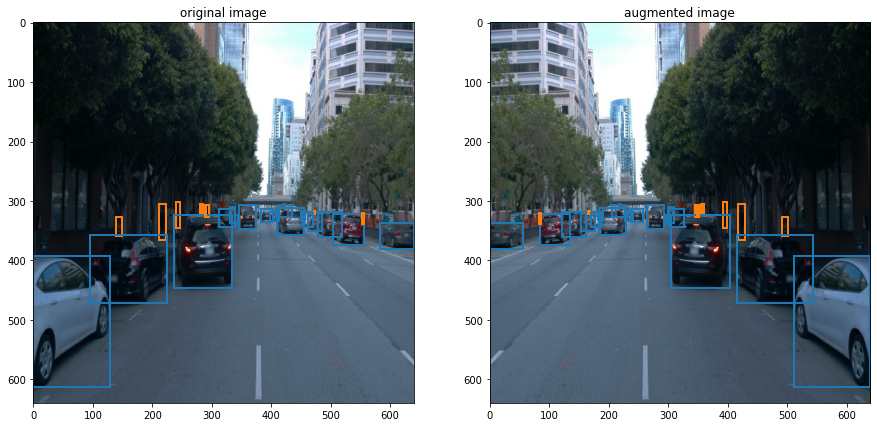

In [13]:
augmentation_options = [(preprocessor.random_horizontal_flip, {"probability": 1.0})]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Random Vertical Flip

```
  data_augmentation_options {
    random_vertical_flip {
    }
  }
```

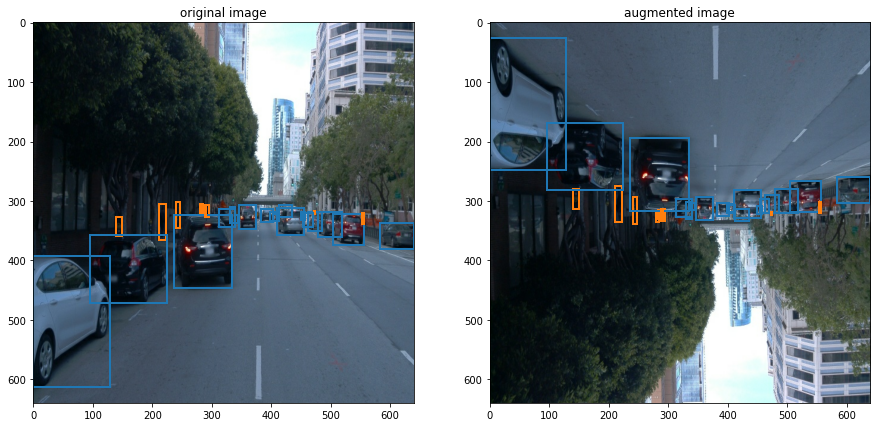

In [14]:
augmentation_options = [(preprocessor.random_vertical_flip, {"probability": 1.0})]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Rotate between 0 ... 90° in 90° Steps

```
  data_augmentation_options {
    random_rotation90 {
    }
  }
```

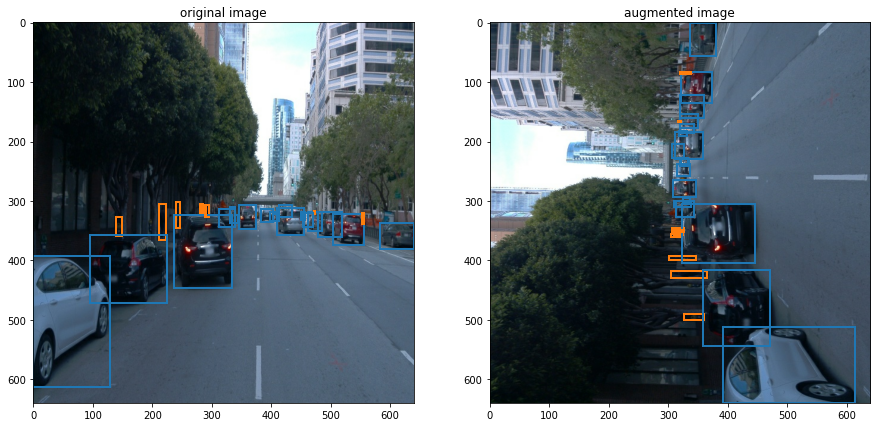

In [15]:
augmentation_options = [(preprocessor.random_rotation90, {"probability": 1.0})]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Rotate between 0 ... 180° in 90° Steps

```
  data_augmentation_options {
    random_rotation90 {
    }
  }
  data_augmentation_options {
    random_rotation90 {
    }
  }
```

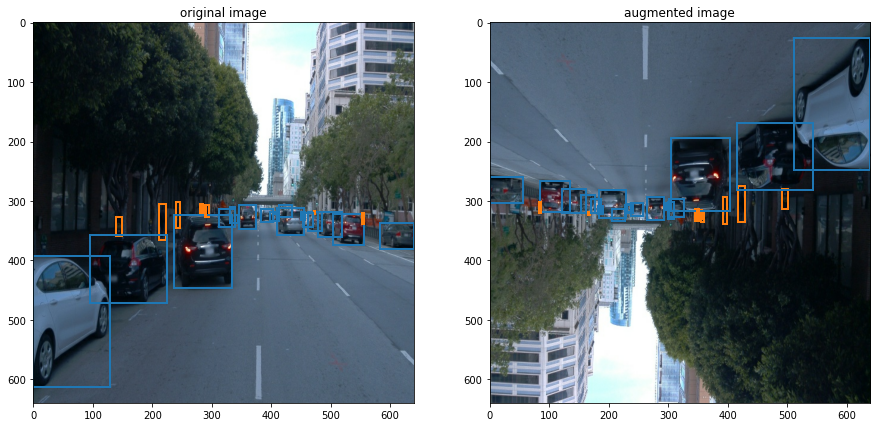

In [16]:
augmentation_options = [
    (preprocessor.random_rotation90, {"probability": 1.0}),
    (preprocessor.random_rotation90, {"probability": 1.0}),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Rotate between 0 ... 270° in 90° Steps

```
  data_augmentation_options {
    random_rotation90 {
    }
  }
  data_augmentation_options {
    random_rotation90 {
    }
  }
  data_augmentation_options {
    random_rotation90 {
    }
  }
```

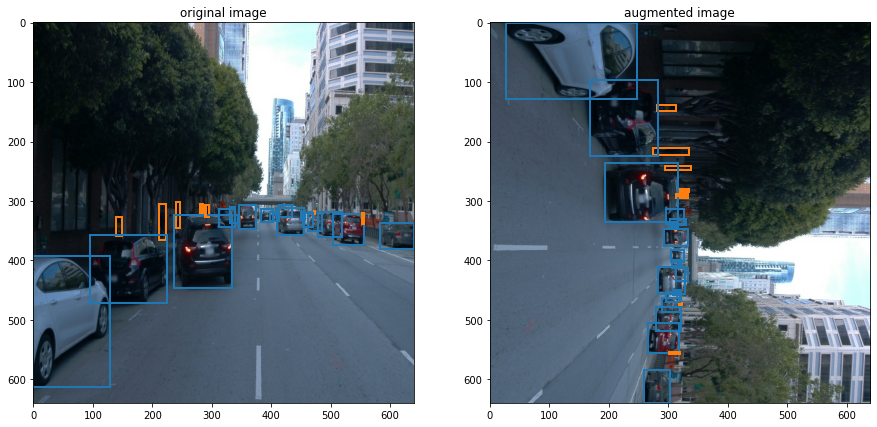

In [17]:
augmentation_options = [
    (preprocessor.random_rotation90, {"probability": 1.0}),
    (preprocessor.random_rotation90, {"probability": 1.0}),
    (preprocessor.random_rotation90, {"probability": 1.0}),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Adjust Saturation

```
  data_augmentation_options {
    random_adjust_saturation {
        min_delta: 0.5,
        max_delta: 1.5
    }
  }
```

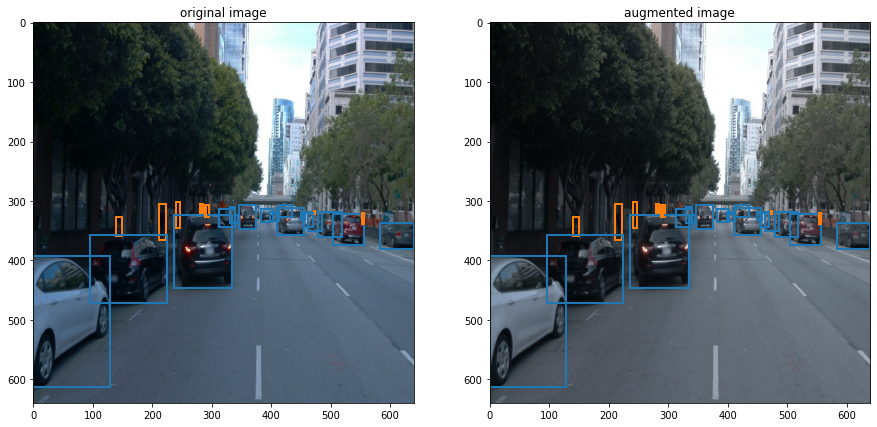

In [24]:
augmentation_options = [
    (preprocessor.random_adjust_saturation, {
        "min_delta": 0.5,
        "max_delta": 1.5,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Adjust Brightness

```
  data_augmentation_options {
    random_adjust_brightness {
        max_delta: 0.3
    }
  }
```

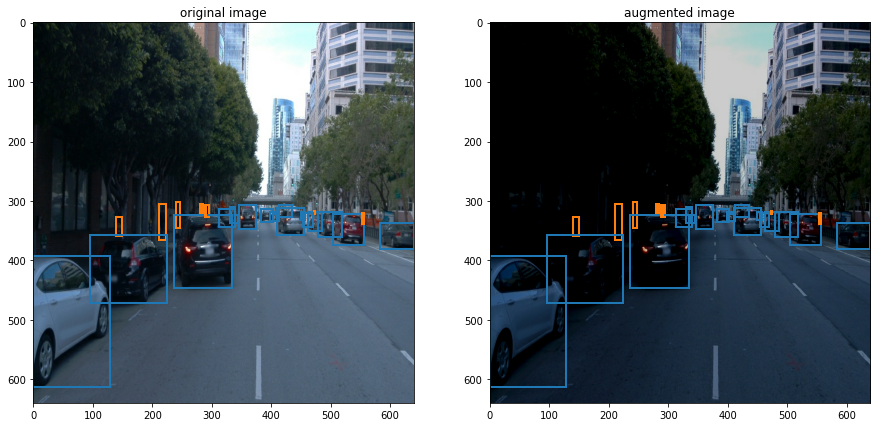

In [26]:
augmentation_options = [
    (preprocessor.random_adjust_brightness, {
        "max_delta": 0.3,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Adjust Hue

```
  data_augmentation_options {
    random_adjust_hue {
        max_delta: 0.3
    }
  }
```

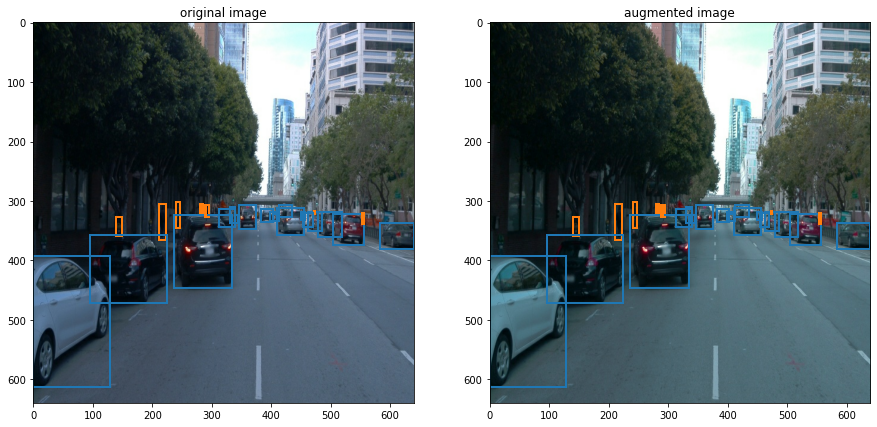

In [27]:
augmentation_options = [
    (preprocessor.random_adjust_hue, {
        "max_delta": 0.1,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Adjust Contrast

```
  data_augmentation_options {
    random_adjust_contrast {
        min_delta: 0.5
        max_delta: 1.5
    }
  }
```

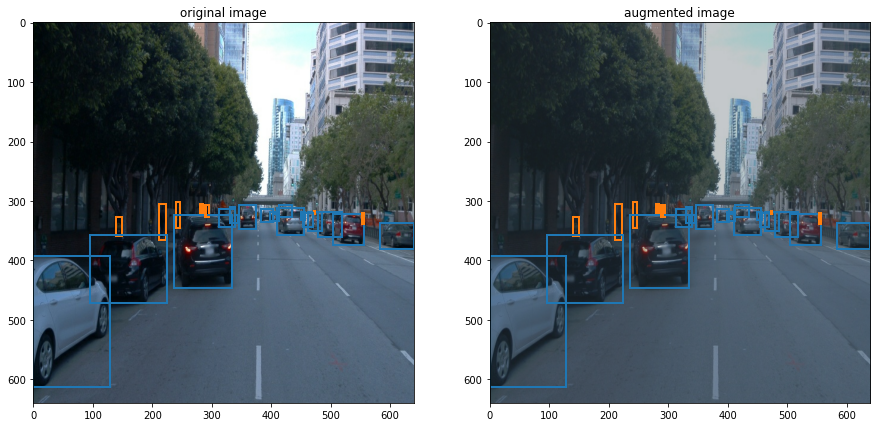

In [33]:
augmentation_options = [
    (preprocessor.random_adjust_contrast, {
        "min_delta": 0.5,
        "max_delta": 1.5,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Convert to Grayscale

```
  data_augmentation_options {
    random_rgb_to_gray {
        probability: 1.0
    }
  }
```

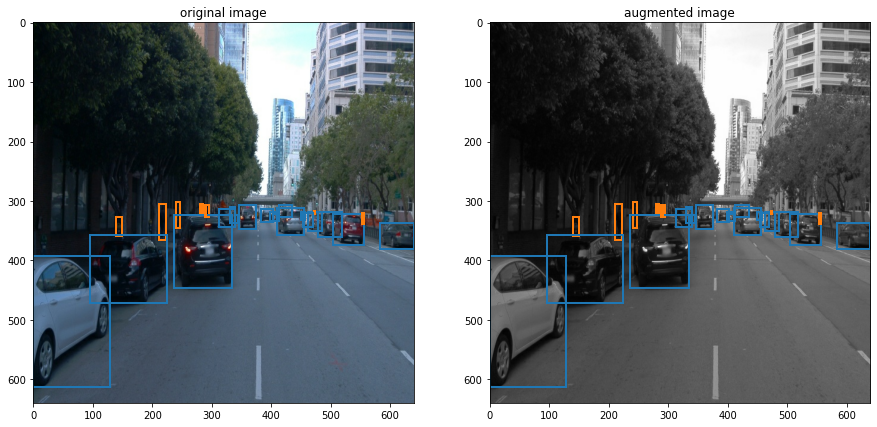

In [34]:
augmentation_options = [
    (preprocessor.random_rgb_to_gray, {
        "probability": 1.0
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly distort color

data_augmentation_options {
    random_distort_color {
      color_ordering: 0
    }

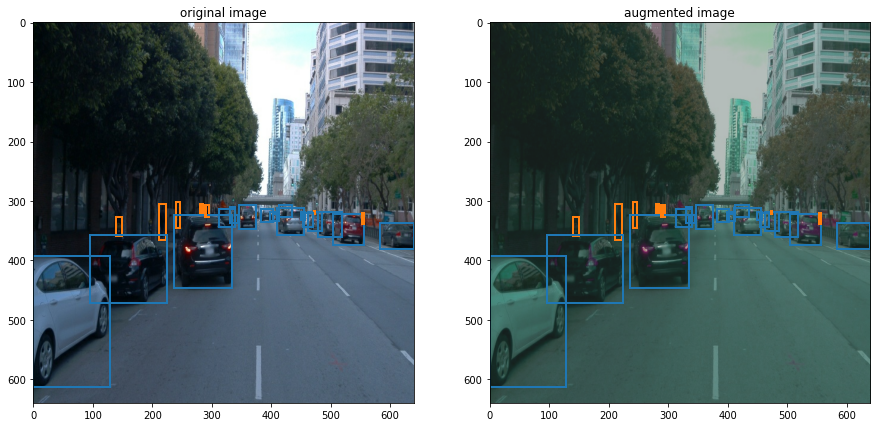

In [35]:
augmentation_options = [
    (preprocessor.random_distort_color, {
        "color_ordering": 0,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Jitter Bounding Box Position

```
  data_augmentation_options {
    random_jitter_boxes {
      ratio: 0.2
      jitter_mode: default
    }
  }
```

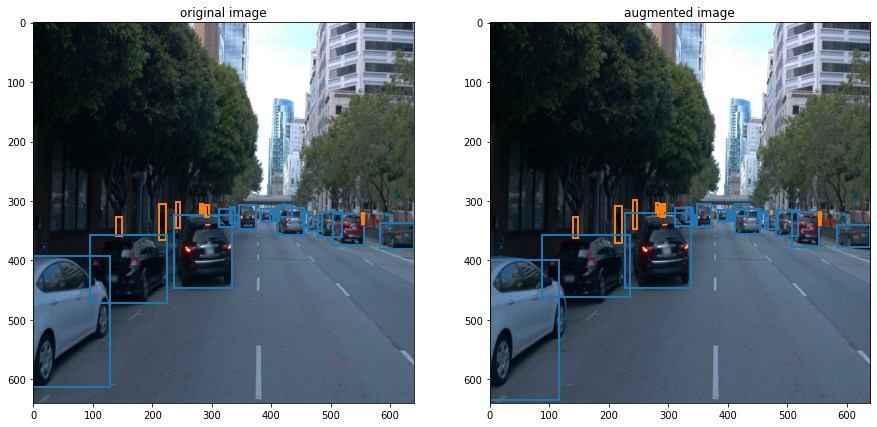

In [36]:
augmentation_options = [
    (preprocessor.random_jitter_boxes, {
        "ratio": 0.2,
        "jitter_mode": 'default',
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Crop Image with Variable Crop Size and Aspect Ratio

```
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
```

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


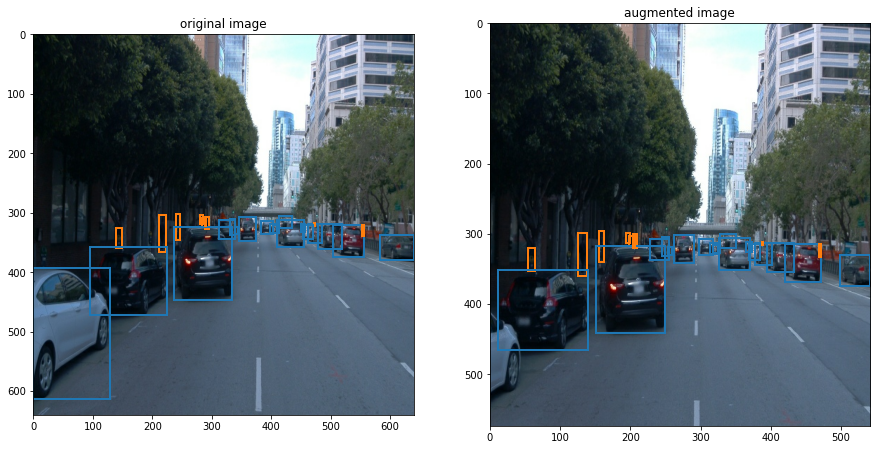

In [37]:
augmentation_options = [
    (preprocessor.random_crop_image, {
        "min_object_covered": 0.0,
        "aspect_ratio_range": (0.75, 3.0),
        "area_range": (0.75, 1.0),
        "overlap_thresh": 0.3,
        "clip_boxes": True,
        "random_coef": 0.0,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

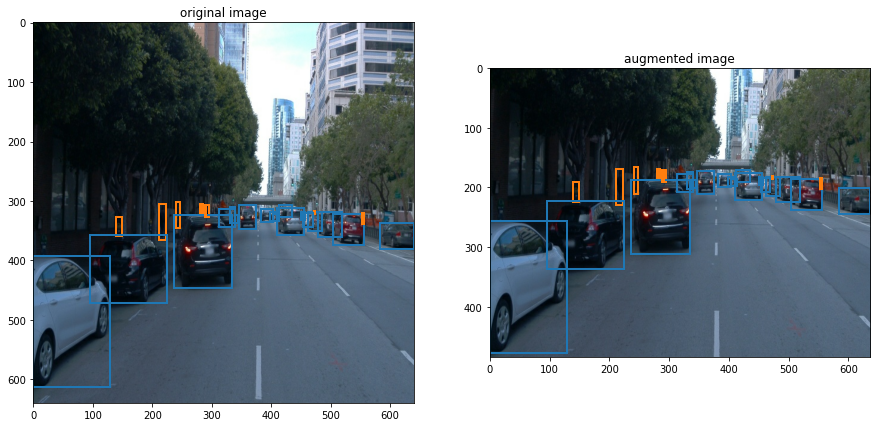

In [38]:
augmentation_options = [
    (preprocessor.random_crop_image, {
        "min_object_covered": 0.75,
        "aspect_ratio_range": (0.75, 1.5),
        "area_range": (0.75, 1.0),
        "overlap_thresh": 0.5,
        "clip_boxes": True,
        "random_coef": 0.125,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Flip Image Horizontally and/or Crop with Variable Crop Size and Aspect Ratio

```
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
```

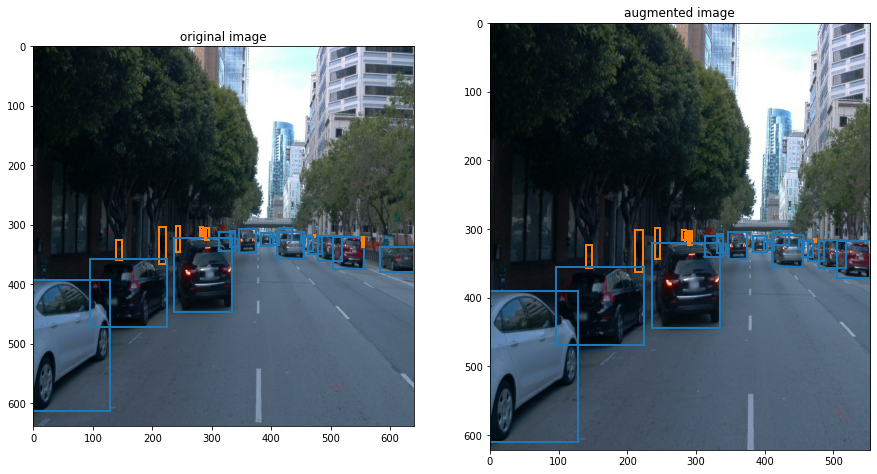

In [40]:
# default augmentation method for ssd_resnet50
augmentation_options = [
    (preprocessor.random_horizontal_flip, {}),
    (preprocessor.random_crop_image, {
        "min_object_covered": 0.0,
        "aspect_ratio_range": (0.75, 3.0),
        "area_range": (0.75, 1.0),
        "random_coef": 0.0,
        "overlap_thresh": 0.0,
        "clip_boxes": True,
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)

### Randomly Crop and Pad Image

```
  data_augmentation_options {
    random_crop_pad_image {
      min_object_covered: 0.75
      min_aspect_ratio: 0.75
      max_aspect_ratio: 1.5
      min_area: 0.25
      max_area: 1.0
      overlap_thresh: 0.5
      clip_boxes: True
      random_coef: 0.5
    }
  }
```

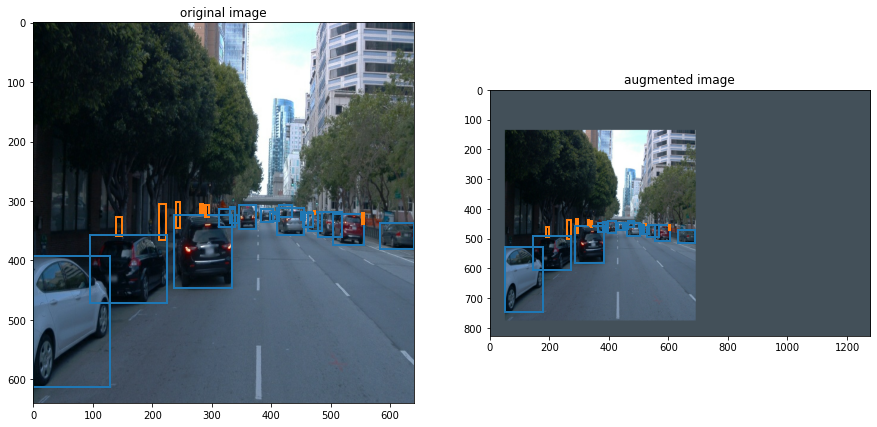

In [41]:
augmentation_options = [
    (preprocessor.random_crop_pad_image, {
        "min_object_covered": 0.75,
        "aspect_ratio_range": (0.75, 1.5),
        "area_range": (0.25, 1.0),
        "random_coef": 0.5,
        "overlap_thresh": 0.5,
        "clip_boxes": True,
        "min_padded_size_ratio": (0.1, 0.1),
        "max_padded_size_ratio": (2.0, 2.0),
    }),
]
augmented_image, augmented_bboxes, augmented_classes = show_augmentation_effect(
    image, bboxes, classes, augmentation_options, class_color_idx)